<a href="https://colab.research.google.com/github/nemo-algorithm/AI/blob/master/%5BSoil_Mechanics%5DGrain_Size_Distribution_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Draw Grain-Size Distribution Curve with python !

> Created Date : 2020-09-16, Last Update : 2020-09-16<br>
> Writer : Nemo (nemo-algorithm AT korea.ac.kr)

토질역학 과제하다 파이썬 그래프 그리는 거 연습하려고 그냥 짜본 코드...지만 너무 손이 많이 갔다.<br>

짠 거 아까워서 잔디나 심어야지 ~

#### Data from Assignment

|  체  |  3in  | 1.5in | 0.74in |  #4   |  #10  | #20  |  #40  |  #60  | #100  | #200 | Pan  |
| :--: | :---: | :---: | :----: | :---: | :---: | :--: | :---: | :---: | :---: | :--: | :--: |
|  A   | 0 | 212.3 | 142.6 | 209.1 | 152.2 | - | 93.6 | - | 52.8 | 61.6 | 32.3 |
|  B   |  499  |  499  |  499   |  499  |  499  | 464  | 408.4 | 326.2 | 195.7 | 75.2 | 15.2 |


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import bisect

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
"""
Data from Assignment
"""
grain_size = np.array([100, 50, 10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05])
sieve_num = np.array(["3in", "1.5in", "0.74in", "#4", "#10", "#20", "#40", "#60", "#100", "#200"])
sieve_size = np.array([76.2, 38.1, 18.80, 4.750, 2.000, 0.850, 0.425, 0.250, 0.150, 0.075])
A_sieve_size = np.array([76.2, 38.1, 18.80, 4.750, 2.000, 0.425, 0.150, 0.075])
B_sieve_size = np.array([76.2, 38.1, 18.80, 4.750, 2.000, 0.850, 0.425, 0.250, 0.150, 0.075])
A = np.array([0, 212.3, 142.6, 209.1, 152.2, 93.6, 52.8, 61.6, 32.3])
B = np.array([0, 0, 0, 0, 35.0, 55.6, 82.2, 130.5, 120.5, 60.0, 15.2])

In [3]:
"""
Data Preprocessing
"""
for i in range(len(A)-2, -1, -1): A[i] = A[i] + A[i+1]
for i in range(len(B)-2, -1, -1): B[i] = B[i] + B[i+1]
for i in reversed(range(len(A))): A[i] = A[i] * 100 / A[0]
for i in reversed(range(len(B))): B[i] = B[i] * 100 / B[0]

# show percent
print(A)
print(B)

# remove Pan
A, B = A[:-1], B[:-1]

[100.         100.          77.80449556  62.89597491  41.03502352
  25.1228437   15.33716675   9.8170413    3.37689493]
[100.         100.         100.         100.         100.
  92.98597194  81.84368737  65.37074148  39.21843687  15.07014028
   3.04609218]


## 보간
3차 스플라인 보간의 이계도함수를 깎았으며, f(x), inv(y) 함수를 구현하여 입경 계산을 편하게 하였다.

뒤늦게 깨달은 점이 스플라인에 적합한 데이터가 아니었으며, 이를 수습하기 위해 어줍잖게 Smoothing을 해보았는데 곡선이 그리 예쁘지 않다.

정점에서 미분 불가능하다는 점이 불편하지만, **Spline에 smoothing을 0으로 설정해보면 미분 가능한 그래프를 잘 그리긴 한다.** 하지만 3차 스플라인 곡선은 결정적이며 그래프를 보면 ... 좀 그렇다. 보간을 뺄까도 생각해보았고 로그 스케일에서 선형 보간해도 이상해서 많은 고민을 한 결과 이계도함수에 Smoothing을 가하기로 결정했다.

In [4]:
class Cubic:
    def __init__(self, a, b, c, d, x_t):
        smooth = 1.0
        self.a, self.b, self.c, self.d, self.x_t = a , b * smooth, c * smooth, d * smooth, x_t * smooth

    def f(self, x):
        return self.d * ((x - self.x_t)**3) + self.c * ((x - self.x_t)**2) + self.b * (x - self.x_t) + self.a

    def inv(self, y, x_l, x_r):
        l, r = x_l, x_r
        if(x_l<1.6): x_r = 0.053
        while True:
            m = (l + r) / 2
            if self.f(m) >= y:
                r = m
            else: l = m
            if r - l < 0.0001: return m

class Spline:
    """
    Cubic Spline Interpolation

    Initialize : Spline(x, y, smooth=0.40)
    function : f(x), inv(y)
    * f, inv work on increasing discrete data

    Reference Pseudo Code : https://en.wikipedia.org/wiki/Spline_(mathematics)
    """
    def __init__(self, x, y, smooth=0.40):

        assert len(x) == len(y), "different length error"
        N = len(x) - 1

        self.N = N
        self.x = copy.deepcopy(x)
        self.y = copy.deepcopy(y)
        self.data = [Cubic(0, 0, 0, 0, 0)] * N

        a = copy.deepcopy(y)
        b, d, h, alpha = [0] * N, [0] * N, [0] * N, [0] * N
        c, l, mu, z = [0] * (N+1), [0] * (N+1), [0] * (N+1), [0] * (N+1)

        l[0], l[N] = 1, 1

        for i in range(N):
            h[i] = x[i+1] - x[i]
            if i != 0:
                alpha[i] = 3 * (a[i+1] - a[i]) / h[i] - 3 * (a[i] - a[i-1]) / h[i-1]

        for i in range(1, N):
            l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * mu[i-1]
            mu[i] = h[i] / l[i]
            z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]
        
        for i in range(N-1, -1, -1):
            c[i] = smooth * z[i] - mu[i] * c[i+1]
            b[i] = (a[i+1] - a[i]) / h[i] - h[i] * (c[i+1] + 2 * c[i]) / 3
            d[i] = (c[i+1] - c[i]) / (3 * h[i])
        
        for i in range(N):
            self.data[i] = Cubic(a[i], b[i], c[i], d[i], x[i])

        for i in range(N-1, -1, -1):
            """
            do not interpolate y == 100
            """
            if y[i] == y[i+1]:
                self.data[i] = Cubic(100, 0, 0, 0, x[i])
            else: break

    
    def f(self, x):
        index = bisect.bisect_right(self.x, x) - 1
        if x < self.x[0]: index = 0
        if x > self.x[-1] or index >= self.N: index = self.N - 1
        return self.data[index].f(x)
    
    def inv(self, y):
        index = bisect.bisect_right(self.y, y) - 1
        if y < self.y[0]: index = 0
        if y > self.y[-1] or index >= self.N: index = self.N - 1
        return self.data[index].inv(y, self.x[index], self.x[index+1])

A_spline = Spline(list(reversed(A_sieve_size)), list(reversed(A))) # a, b, c, d
B_spline = Spline(list(reversed(B_sieve_size)), list(reversed(B)))

A_X_interpolate = list(reversed(np.logspace(np.log10(A_sieve_size[-1]), np.log10(A_sieve_size[0]), 1000, base=10, endpoint=True).tolist()))
B_X_interpolate = list(reversed(np.logspace(np.log10(B_sieve_size[-1]), np.log10(B_sieve_size[0]), 1000, base=10, endpoint=True).tolist()))
A_interpolate = [A_spline.f(x) for x in A_X_interpolate]
B_interpolate = [B_spline.f(x) for x in B_X_interpolate]

## 그래프

로그 스케일인 x축의 상단에 체의 크기를 정확한 위치에 표시하기 위해 나름의 공을 들였다.

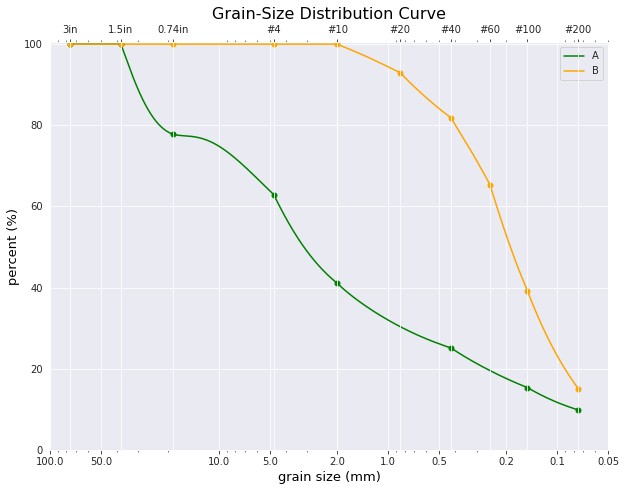

In [5]:
"""
Draw Graph
"""
# setting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(1,1,1)

# set x-axis (grain size)
ax.set_xscale('log')
ax.set_xlabel('grain size (mm)',fontdict = {
    'family': 'DejaVu Sans', 'fontsize': 13, 'color': 'black'
})
ax.set_ylabel('percent (%)',fontdict = {
    'family': 'DejaVu Sans', 'fontsize': 13, 'color': 'black'
})
ax.set_xlim(grain_size[0], grain_size[-1])
ax.set_xticks(grain_size)
ax.set_xticklabels(iter(grain_size))

# set secondary axis (size2num)
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(grain_size[0], grain_size[-1])
ax2.set_ylim(0, 100.5)
ax2.set_xticks(sieve_size)
ax2.set_xticklabels(iter(sieve_num))

# draw graph
plt.title("Grain-Size Distribution Curve", fontdict = {
    'family': 'DejaVu Sans', 'fontsize': 16, 'color': 'black'
})

ax.plot(A_X_interpolate, A_interpolate, color='green')
ax.plot(B_X_interpolate, B_interpolate, color='orange')

ax.plot(A_sieve_size, A, color='green', linestyle='', marker='.', markersize=10)
ax.plot(B_sieve_size, B, color='orange', linestyle='', marker='.', markersize=10)
ax.legend(['A','B'], )
plt.show()

## Effective Size & Uniformity Coefficient, Coefficient of Gradation

In [6]:
"""
Calculate effective size
"""
A_D10, A_D30, A_D60 = A_spline.inv(10), A_spline.inv(30), A_spline.inv(60)
B_D10, B_D30, B_D60 = B_spline.inv(10), B_spline.inv(30), B_spline.inv(60)
print(A_D10, A_D30, A_D60)
print(B_D10, B_D30, B_D60)

0.07741699218749999 0.8169235229492189 4.384010314941406
0.0750732421875 0.12106933593749998 0.22783203125


In [7]:
"""
Calculate uniformity coefficient & coefficient of gradation
"""
A_Cu, A_Cc = A_D60 / A_D10, A_D30**2 / (A_D60 * A_D10)
B_Cu, B_Cc = B_D60 / B_D10, B_D30**2 / (B_D60 * B_D10)
print(A_Cu, A_Cc)
print(B_Cu, B_Cc)

56.628528066855885 1.9663233738582613
3.03479674796748 0.8569754215759042
